In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')
savefigs = False

/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.30

In [3]:
df = pd.read_csv('data/prepped_data.csv')
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [4]:
dfm = df.groupby(['time', 'unit']).mean()['count'].unstack(level=0)

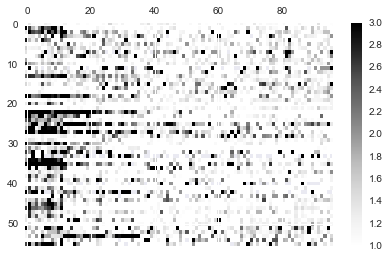

In [5]:
plt.matshow(dfm.values[:, 1::3] / dfm.values[:, ::3], 
            aspect='auto', vmin=1, vmax=3)
plt.colorbar();

In [6]:
dfmm = df.groupby('time').mean()['count']

<Container object of 3 artists>

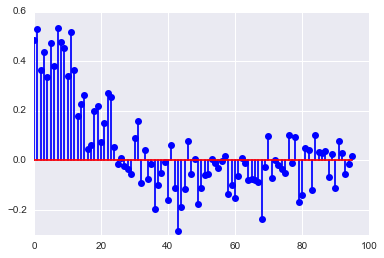

In [7]:
dfrel = (dfmm.values[1::3] - dfmm.values[::3])/dfmm.values[1::3]
plt.stem(range(len(dfrel)), dfrel)

In [8]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,0,0,2,-1.659158,-1.826799
1,1,0,1,-1.849769,-1.679158
2,2,0,2,-0.578987,-1.016018
3,3,0,0,-0.271700,-0.203939
4,4,0,3,-0.743339,-1.430097


In [9]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [10]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(288, 10)


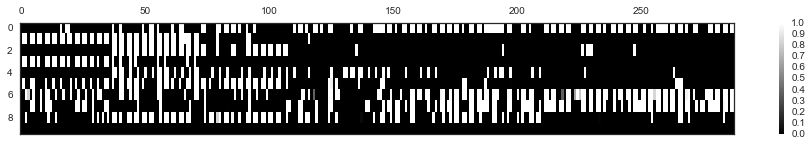

In [11]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

Every third timestep is a different stimulus. Each stimulus has
1. pre-trial baseline
1. stimulus presentation
1. post-stimulus period

So let's plot these individually:

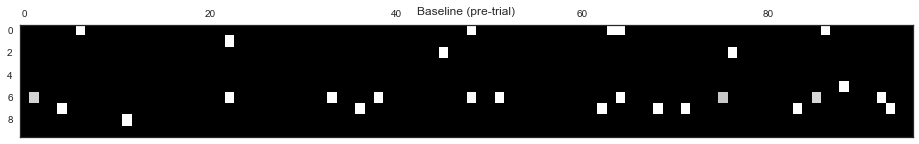

In [12]:
matshow(xi[::3].T, vmin=0, vmax=1)
plt.title('Baseline (pre-trial)')

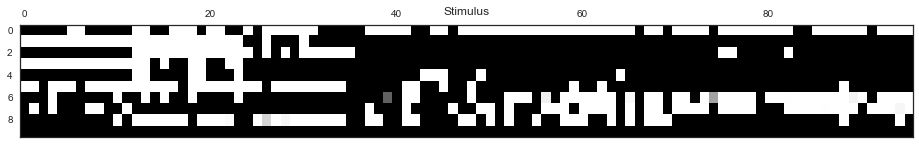

In [13]:
matshow(xi[1::3].T, vmin=0, vmax=1)
plt.title('Stimulus')

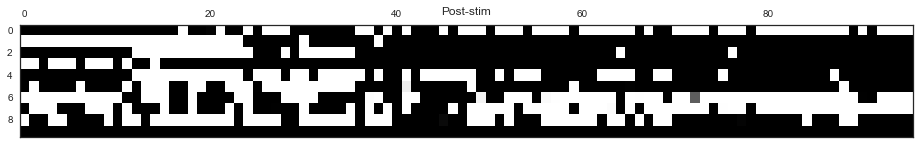

In [14]:
matshow(xi[2::3].T, vmin=0, vmax=1)
plt.title('Post-stim')

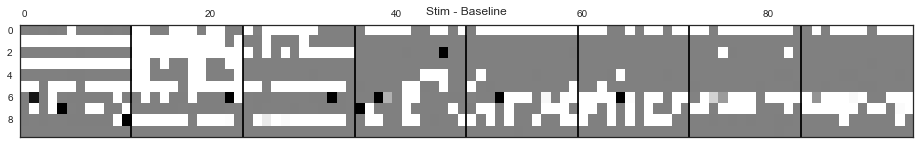

In [15]:
matshow(xi[1::3].T - xi[::3].T, vmin=-1, vmax=1)
plt.title('Stim - Baseline')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

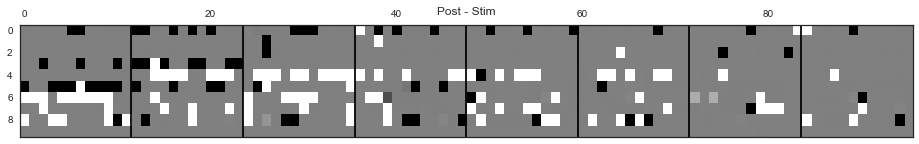

In [16]:
matshow(xi[2::3].T - xi[1::3].T, vmin=-1, vmax=1)
plt.title('Post - Stim')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

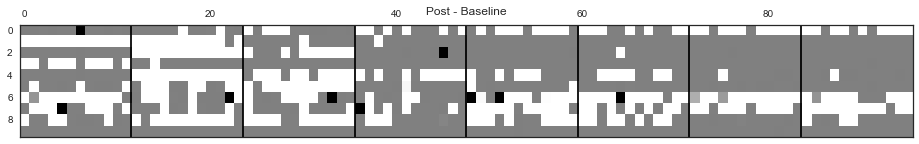

In [17]:
matshow(xi[2::3].T - xi[::3].T, vmin=-1, vmax=1)
plt.title('Post - Baseline')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

## Weight categories by effect sizes

First, get mean effect size for each firing rate effect:

In [18]:
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

effsize = th_pars[0] / th_pars[1]  # mean of posterior for mean effect size

In [19]:
effsize

array([ 0.95965097,  0.88440285,  1.0098406 ,  0.77798307,  1.22389374,
        0.87332988,  1.06287643,  0.93351161,  1.0915169 ,  1.32906375])

In [20]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_invalid(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=1., vmin=0.8, vmax=1.2)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

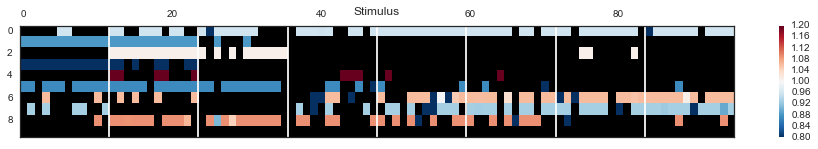

In [21]:
X = (xi[1::3] * effsize).T
X[np.abs(X) < 1e-4] = np.nan

with sns.axes_style("white"):
    plt.figure(figsize=(20, 8))
    ax = plt.matshow(X, aspect='auto', cmap=cmap, norm=norm);

plt.title('Stimulus')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.colorbar();

## Make $\xi$ dataframe:

In [22]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [23]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

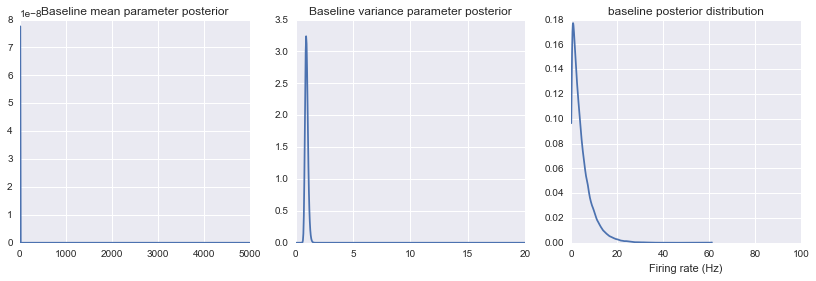

In [24]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [25]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [26]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

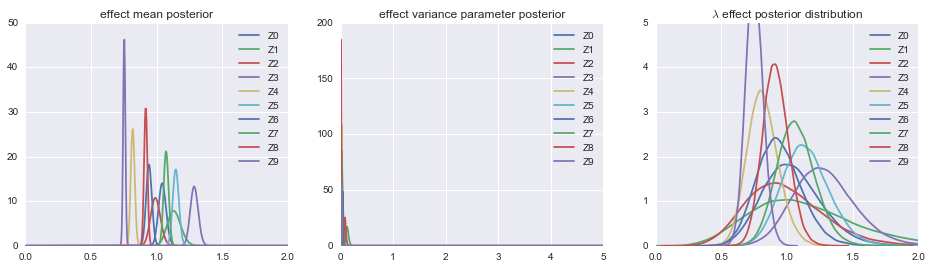

In [27]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

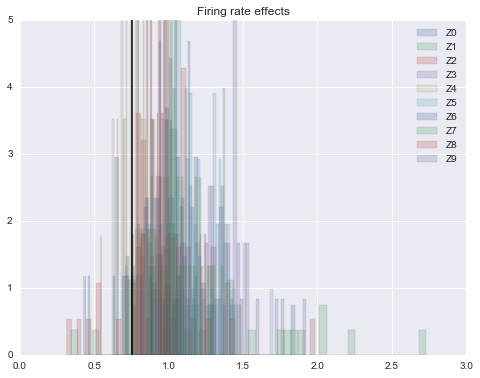

In [28]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

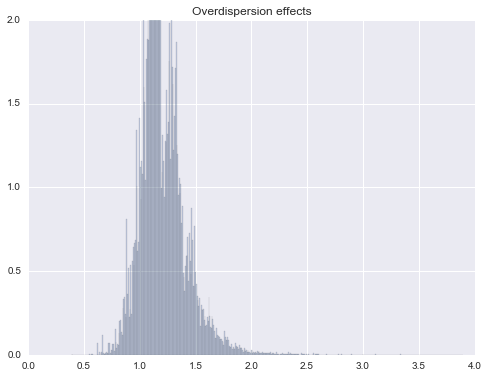

In [29]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

In [30]:
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [31]:
df2 = df.copy()
df2['value'] = 1
df2 = df2.drop(['trial', 'unit'], axis=1).drop_duplicates()
catdf = pd.pivot_table(df2, values='value', index=['time'], columns=['category']).reset_index().fillna(0)
catdf.columns.name = ''
catdf.head()

,time,Animals,Baseline,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene
0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0
2,2,0,0,0,1,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0
4,4,0,0,0,1,0,0,0,0,0


In [46]:
edf = pd.merge(catdf, xif).sort_values(by='time').drop(['time', 'Baseline'], axis=1)
edf.head()

,Animals,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,4.852948e-14,8.561162e-64,2.327285e-20,3.982953e-34,1.313929e-22,1.634828e-15,9.947864e-11,3.076047e-16,1.273612e-11,5.746971e-29
1,0,0,1,0,0,0,0,0,8.878051e-08,1.000000e+00,2.414077e-52,1.000000e+00,6.352249e-38,1.000000e+00,2.432463e-47,1.383467e-37,5.837018e-15,5.250327e-54
2,0,0,1,0,0,0,0,0,5.884222e-22,1.000000e+00,9.892105e-42,1.000000e+00,4.022749e-31,4.591772e-16,1.000000e+00,4.515040e-17,1.000000e+00,1.496608e-38
3,0,0,0,0,0,0,0,0,3.185010e-12,3.809676e-54,6.639567e-29,3.784418e-25,1.909925e-34,1.755885e-11,8.281477e-01,1.560637e-10,2.002826e-17,1.331814e-37
4,0,0,1,0,0,0,0,0,1.059464e-47,1.000000e+00,5.790991e-91,1.000000e+00,2.483735e-69,1.000000e+00,3.677512e-13,1.000000e+00,1.765863e-33,2.945037e-68


# View results:

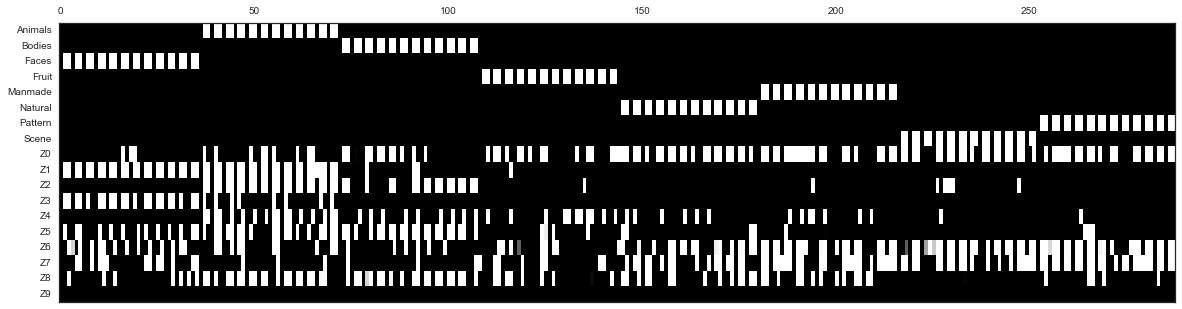

In [47]:
if savefigs:
    sns.set_context('poster', font_scale=1)

# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = edf.columns
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

if savefigs:
    plt.savefig('roitman_recovery.svg')
    sns.set()

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [48]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

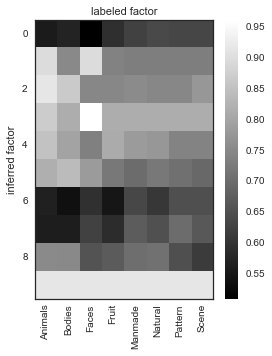

In [49]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [50]:
overlap.iloc[-K:, :]

,Animals,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
,,,,,,,,,,,,,,,,,,
Z0,0.558994,0.572899,0.510275,0.593608,0.628332,0.642244,0.635323,0.635275,0.999661,0.513918,0.558994,0.513747,0.572915,0.537968,0.692400,0.711475,0.610793,0.579720
Z1,0.899306,0.753472,0.899306,0.739583,0.732639,0.732639,0.732639,0.732639,0.513918,1.000000,0.836806,0.916667,0.767361,0.823083,0.577801,0.552350,0.721491,0.815972
Z2,0.916667,0.868056,0.750000,0.750000,0.756945,0.750000,0.750000,0.777778,0.558994,0.836806,0.999999,0.788195,0.812500,0.840445,0.539569,0.528044,0.773285,0.833334
Z3,0.871528,0.815972,0.961806,0.815972,0.815972,0.815972,0.815972,0.815972,0.513747,0.916667,0.788195,1.000000,0.760417,0.816139,0.591689,0.600961,0.680992,0.899306
Z4,0.854167,0.798611,0.736111,0.812500,0.784722,0.777778,0.743056,0.743056,0.572915,0.767361,0.812500,0.760417,1.000000,0.756774,0.546546,0.576503,0.705758,0.819444
Z5,0.819611,0.840485,0.784889,0.721947,0.701621,0.722389,0.708501,0.694612,0.537968,0.823083,0.840445,0.816139,0.756774,0.999470,0.553283,0.534827,0.767692,0.777945
Z6,0.567383,0.539606,0.595161,0.549131,0.636558,0.608150,0.650378,0.650834,0.692400,0.577801,0.539569,0.591689,0.546546,0.553283,0.989824,0.748721,0.577646,0.588217
Z7,0.562767,0.562810,0.625267,0.590507,0.673709,0.653020,0.701360,0.666886,0.711475,0.552350,0.528044,0.600961,0.576503,0.534827,0.748721,0.999362,0.587466,0.625267
Z8,0.753895,0.752622,0.656847,0.671047,0.705458,0.712398,0.649885,0.615335,0.610793,0.721491,0.773285,0.680992,0.705758,0.767692,0.577646,0.587466,0.998077,0.698512


## Mutual Information

In [51]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

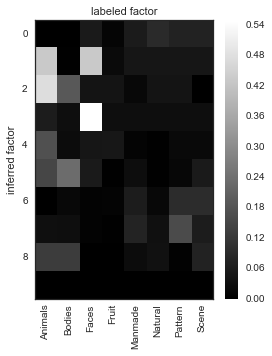

In [52]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=0.55)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [39]:
pd.DataFrame(mi_mat.T, columns=row_labels)

,Animals,Baseline,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene
0,0.000850,0.250355,6.313859e-04,5.776618e-02,1.105541e-02,0.059241,9.227906e-02,7.458543e-02,7.447250e-02
1,0.432620,0.124717,3.110570e-03,4.326196e-01,2.212468e-02,0.048054,4.805380e-02,4.805380e-02,4.805380e-02
2,0.476533,0.092881,1.909443e-01,4.432176e-02,4.432176e-02,0.018823,4.432176e-02,4.432176e-02,8.097317e-12
3,0.062219,0.095621,3.024604e-02,5.578057e-01,3.024604e-02,0.030246,3.024604e-02,3.024604e-02,3.024604e-02
4,0.171944,0.151105,2.642673e-02,4.730417e-02,5.148070e-02,0.009173,3.721473e-03,2.145832e-02,2.145831e-02
5,0.151113,0.152295,2.336730e-01,5.737408e-02,2.425757e-03,0.029462,2.201665e-03,1.576610e-02,5.640997e-02
6,0.000581,0.174666,1.908164e-02,7.055122e-03,9.568741e-03,0.061550,1.805202e-02,9.482639e-02,9.610641e-02
7,0.032296,0.174418,3.222031e-02,6.785852e-03,3.192844e-03,0.075635,3.651885e-02,1.621760e-01,6.091533e-02
8,0.133003,0.215513,1.289699e-01,1.410301e-03,5.751960e-04,0.027225,3.722087e-02,4.777662e-03,7.384504e-02
9,0.000002,0.000003,1.581607e-07,9.127404e-07,8.979944e-07,0.000010,9.041616e-07,9.127404e-07,9.127386e-07
